In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sidharkal/sports-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sidharkal/sports-image-classification/versions/1


In [ ]:
import pandas as pd
import os
# Define file paths
train_csv = path + "/dataset/train.csv"
test_csv = path + "/dataset/test.csv"
image_directory =image_directory = path + "/dataset/train/"
# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (8227, 2)
Test shape: (2056, 1)


<Axes: xlabel='label', ylabel='count'>

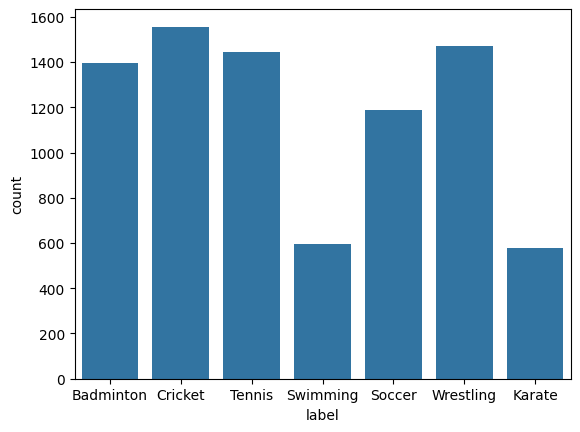

In [ ]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [ ]:
train

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


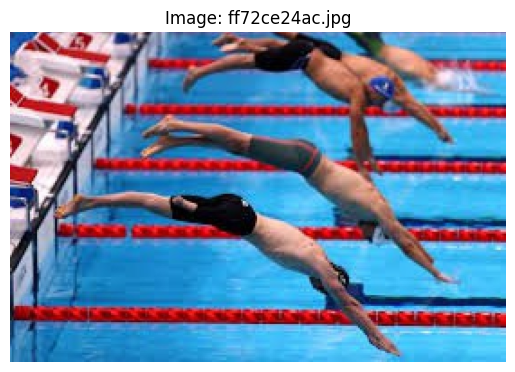

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the image file name
image_filename = "ff72ce24ac.jpg"

# Construct the full path to the image using your existing directory
image_path = os.path.join(image_directory, image_filename)

# Check if the image exists
if os.path.exists(image_path):
    # Load the image (convert from BGR to RGB for Matplotlib)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title(f"Image: {image_filename}")
    plt.axis('off')  # Turn off axes for cleaner display
    plt.show()
else:
    print(f"Image {image_filename} not found in {image_directory}.")

In [ ]:
import os
import cv2
import pandas as pd

# Classes to process
target_classes = ["Swimming", "Karate"]

# Filter the train data for the target classes
filtered_data = train[train["label"].isin(target_classes)]
print(filtered_data)

# Loop through the filtered data
for _, row in filtered_data.iterrows():
    image_id = row["image_ID"]  # File name
    label = row["label"]  # Class label

    # Construct the input image path
    image_path = os.path.join(image_directory, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)

        # Define new sizes for upsampling and downsampling
        new_size_up = (image.shape[1] * 2, image.shape[0] * 2)  # Double size
        new_size_down = (image.shape[1] // 2, image.shape[0] // 2)  # Half size

        # Perform resizing using nearest-neighbor interpolation
        # Uncomment one of these lines based on your goal:
        image = cv2.resize(image, new_size_up, interpolation=cv2.INTER_NEAREST)  # Upsampling
        # image = cv2.resize(image, new_size_down, interpolation=cv2.INTER_NEAREST)  # Downsampling

        # Save the modified image back to the same path
        cv2.imwrite(image_path, image)
        print(f"Modified {image_id} ({label}) directly in the train folder.")
    else:
        print(f"Image {image_id} not found in {image_directory}.")

print("Modification complete for selected classes.")


            image_ID     label
7     da4d3e218c.jpg  Swimming
29    84f0137b10.jpg  Swimming
30    f97066d496.jpg  Swimming
36    c7657216ce.jpg    Karate
37    6a2d3a4a4c.jpg  Swimming
...              ...       ...
8206  e5d42b9d58.jpg    Karate
8217  ff72ce24ac.jpg  Swimming
8219  a7080caa11.jpg    Karate
8221  ea6b657b01.jpg    Karate
8226  f07f00564e.jpg  Swimming

[1173 rows x 2 columns]
Modified da4d3e218c.jpg (Swimming) directly in the train folder.
Modified 84f0137b10.jpg (Swimming) directly in the train folder.
Modified f97066d496.jpg (Swimming) directly in the train folder.
Modified c7657216ce.jpg (Karate) directly in the train folder.
Modified 6a2d3a4a4c.jpg (Swimming) directly in the train folder.
Modified 1d82aeffe8.jpg (Swimming) directly in the train folder.
Modified 8116da71f7.jpg (Karate) directly in the train folder.
Modified fcb5b0e345.jpg (Swimming) directly in the train folder.
Modified 4c03de88f8.jpg (Karate) directly in the train folder.
Modified c5063.jpg (Swim

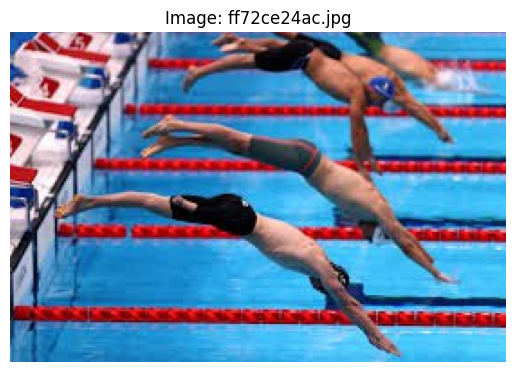

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the image file name
image_filename = "ff72ce24ac.jpg"

# Construct the full path to the image using your existing directory
image_path = os.path.join(image_directory, image_filename)

# Check if the image exists
if os.path.exists(image_path):
    # Load the image (convert from BGR to RGB for Matplotlib)
    image = cv2.imread(image_path)
    image = cv2.resize(image, new_size_up, interpolation=cv2.INTER_NEAREST)  # Upsampling
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title(f"Image: {image_filename}")
    plt.axis('off')  # Turn off axes for cleaner display
    plt.show()
else:
    print(f"Image {image_filename} not found in {image_directory}.")

ResNet50

In [ ]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [ ]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = path + "/dataset/train"
test_img_dir = test_csv + "dataset/test"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [ ]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:23<00:00,  2.48it/s]


Epoch [1/5], Training Loss: 1.0639, Training Accuracy: 0.6364


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


Epoch [1/5], Validation Loss: 0.8323, Validation Accuracy: 0.7108


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:17<00:00,  2.66it/s]


Epoch [2/5], Training Loss: 0.6671, Training Accuracy: 0.7710


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:20<00:00,  2.59it/s]


Epoch [2/5], Validation Loss: 1.3204, Validation Accuracy: 0.6002


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:14<00:00,  2.75it/s]


Epoch [3/5], Training Loss: 0.5490, Training Accuracy: 0.8099


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]


Epoch [3/5], Validation Loss: 1.0485, Validation Accuracy: 0.6756


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.71it/s]


Epoch [4/5], Training Loss: 0.3912, Training Accuracy: 0.8664


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]


Epoch [4/5], Validation Loss: 0.6699, Validation Accuracy: 0.7874


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:15<00:00,  2.73it/s]


Epoch [5/5], Training Loss: 0.3474, Training Accuracy: 0.8835


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]

Epoch [5/5], Validation Loss: 0.4010, Validation Accuracy: 0.8633
Training completed.


# VGG16

In [ ]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.5MB/s]


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:19<00:00,  2.58it/s]


Epoch [1/5], Training Loss: 1.8871, Training Accuracy: 0.2329


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]


Epoch [1/5], Validation Loss: 1.7257, Validation Accuracy: 0.2758


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.55it/s]


Epoch [2/5], Training Loss: 1.6099, Training Accuracy: 0.3525


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]


Epoch [2/5], Validation Loss: 1.8813, Validation Accuracy: 0.3086


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:20<00:00,  2.55it/s]


Epoch [3/5], Training Loss: 1.4610, Training Accuracy: 0.4259


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:20<00:00,  2.49it/s]


Epoch [3/5], Validation Loss: 1.3152, Validation Accuracy: 0.4957


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:19<00:00,  2.58it/s]


Epoch [4/5], Training Loss: 1.5012, Training Accuracy: 0.4229


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]


Epoch [4/5], Validation Loss: 1.4165, Validation Accuracy: 0.4241


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:19<00:00,  2.58it/s]


Epoch [5/5], Training Loss: 1.4534, Training Accuracy: 0.4303


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]

Epoch [5/5], Validation Loss: 1.4097, Validation Accuracy: 0.4028
Training with VGG16 completed.


# GoogLeNet

In [ ]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 93.6MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:16<00:00,  2.69it/s]


Epoch [1/5], Training Loss: 0.6231, Training Accuracy: 0.7809


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.14it/s]


Epoch [1/5], Validation Loss: 0.4542, Validation Accuracy: 0.8481


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:11<00:00,  2.87it/s]


Epoch [2/5], Training Loss: 0.3346, Training Accuracy: 0.8894


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.20it/s]


Epoch [2/5], Validation Loss: 0.6075, Validation Accuracy: 0.8062


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:12<00:00,  2.82it/s]


Epoch [3/5], Training Loss: 0.2598, Training Accuracy: 0.9138


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]


Epoch [3/5], Validation Loss: 0.3865, Validation Accuracy: 0.8609


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:11<00:00,  2.87it/s]


Epoch [4/5], Training Loss: 0.2032, Training Accuracy: 0.9322


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]


Epoch [4/5], Validation Loss: 0.3813, Validation Accuracy: 0.8791


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:12<00:00,  2.85it/s]


Epoch [5/5], Training Loss: 0.1541, Training Accuracy: 0.9482


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epoch [5/5], Validation Loss: 0.3395, Validation Accuracy: 0.8991
Training with GoogLeNet completed.


# AlexNet

In [ ]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 111MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:07<00:00,  3.03it/s]


Epoch [1/5], Training Loss: 1.9069, Training Accuracy: 0.1801


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epoch [1/5], Validation Loss: 1.8850, Validation Accuracy: 0.1756


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:07<00:00,  3.06it/s]


Epoch [2/5], Training Loss: 1.8907, Training Accuracy: 0.1836


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epoch [2/5], Validation Loss: 1.8891, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:06<00:00,  3.11it/s]


Epoch [3/5], Training Loss: 1.8918, Training Accuracy: 0.1814


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.37it/s]


Epoch [3/5], Validation Loss: 1.8840, Validation Accuracy: 0.1744


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:06<00:00,  3.11it/s]


Epoch [4/5], Training Loss: 1.8901, Training Accuracy: 0.1811


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epoch [4/5], Validation Loss: 1.8858, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:06<00:00,  3.08it/s]


Epoch [5/5], Training Loss: 1.8896, Training Accuracy: 0.1860


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.30it/s]

Epoch [5/5], Validation Loss: 1.8867, Validation Accuracy: 0.1847
Training with AlexNet completed.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sidharkal/sports-image-classification")

print("Path to dataset files:", path)

In [ ]:
import pandas as pd
import os
# Define file paths
train_csv = path + "/dataset/train.csv"
test_csv = path + "/dataset/test.csv"
image_directory =image_directory = path + "/dataset/train/"
# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (8227, 2)
Test shape: (2056, 1)


<Axes: xlabel='label', ylabel='count'>

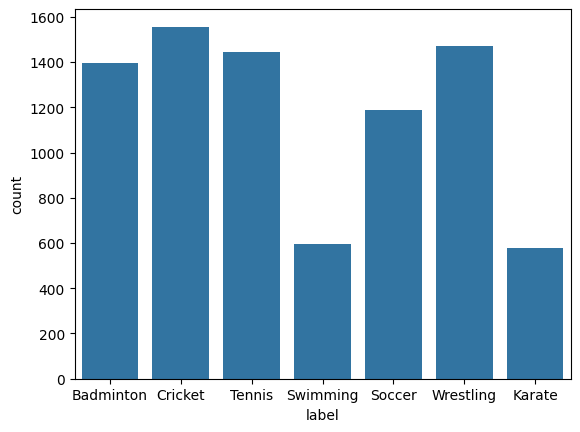

In [ ]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [ ]:
train

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


In [ ]:
import os
import cv2
import pandas as pd

# Classes to process
target_classes = ["Cricket", "Wrestling"]

# Filter the train data for the target classes
filtered_data = train[train["label"].isin(target_classes)]
print(filtered_data)

# Loop through the filtered data
for _, row in filtered_data.iterrows():
    image_id = row["image_ID"]  # File name
    label = row["label"]  # Class label

    # Construct the input image path
    image_path = os.path.join(image_directory, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)

        # Define new sizes for upsampling and downsampling
        new_size_up = (image.shape[1] * 2, image.shape[0] * 2)  # Double size

        # Ensure minimum dimensions of 1x1 after downsampling
        new_size_down = (max(1, image.shape[1] // 2), max(1, image.shape[0] // 2))  # Half size

        # Perform resizing using nearest-neighbor interpolation
        # Uncomment one of these lines based on your goal:
        # image = cv2.resize(image, new_size_up, interpolation=cv2.INTER_NEAREST)  # Upsampling
        image = cv2.resize(image, new_size_down, interpolation=cv2.INTER_NEAREST)  # Downsampling

        # Save the modified image back to the same path
        cv2.imwrite(image_path, image)
        print(f"Modified {image_id} ({label}) directly in the train folder.")
    else:
        print(f"Image {image_id} not found in {image_directory}.")

print("Modification complete for selected classes.")

            image_ID      label
4     cfd2c28c74.jpg    Cricket
10    cdddf0986c.jpg    Cricket
16    598474c7b4.jpg    Cricket
17    772648a478.jpg  Wrestling
21    89ce36a3ec.jpg  Wrestling
...              ...        ...
8207  f8befcae17.jpg    Cricket
8210  e347af0df6.jpg    Cricket
8213  fb1afffcf1.jpg  Wrestling
8215  5e04258d16.jpg    Cricket
8222  903d2fffb3.jpg    Cricket

[3027 rows x 2 columns]
Modified cfd2c28c74.jpg (Cricket) directly in the train folder.
Modified cdddf0986c.jpg (Cricket) directly in the train folder.
Modified 598474c7b4.jpg (Cricket) directly in the train folder.
Modified 772648a478.jpg (Wrestling) directly in the train folder.
Modified 89ce36a3ec.jpg (Wrestling) directly in the train folder.
Modified 28e511a3b9.jpg (Cricket) directly in the train folder.
Modified 4e13ff214a.jpg (Cricket) directly in the train folder.
Modified 88199f586e.jpg (Wrestling) directly in the train folder.
Modified 96d7e3d2a6.jpg (Cricket) directly in the train folder.
Modified 

In [ ]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label

In [ ]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = path + "/dataset/train"
test_img_dir = test_csv + "dataset/test"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training:   0%|          | 0/206 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5 - Training: 100%|██████████| 206/206 [01:02<00:00,  3.30it/s]


Epoch [1/5], Training Loss: 1.8872, Training Accuracy: 0.1902


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.93it/s]


Epoch [1/5], Validation Loss: 1.8848, Validation Accuracy: 0.1847


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:57<00:00,  3.57it/s]


Epoch [2/5], Training Loss: 1.8857, Training Accuracy: 0.1902


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.45it/s]


Epoch [2/5], Validation Loss: 1.8845, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:00<00:00,  3.38it/s]


Epoch [3/5], Training Loss: 1.8860, Training Accuracy: 0.1902


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.90it/s]


Epoch [3/5], Validation Loss: 1.8847, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [00:57<00:00,  3.59it/s]


Epoch [4/5], Training Loss: 1.8860, Training Accuracy: 0.1899


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]


Epoch [4/5], Validation Loss: 1.8847, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:59<00:00,  3.48it/s]


Epoch [5/5], Training Loss: 1.8860, Training Accuracy: 0.1902


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:12<00:00,  4.13it/s]


Epoch [5/5], Validation Loss: 1.8848, Validation Accuracy: 0.1847
Training completed.


In [ ]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:12<00:00,  2.82it/s]


Epoch [1/5], Training Loss: 2.1872, Training Accuracy: 0.1851


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.31it/s]


Epoch [1/5], Validation Loss: 1.8935, Validation Accuracy: 0.1847


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:09<00:00,  2.95it/s]


Epoch [2/5], Training Loss: 1.8943, Training Accuracy: 0.1854


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.19it/s]


Epoch [2/5], Validation Loss: 1.8865, Validation Accuracy: 0.1847


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:09<00:00,  2.95it/s]


Epoch [3/5], Training Loss: 1.8951, Training Accuracy: 0.1717


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.19it/s]


Epoch [3/5], Validation Loss: 1.8886, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:11<00:00,  2.89it/s]


Epoch [4/5], Training Loss: 1.8924, Training Accuracy: 0.1833


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.34it/s]


Epoch [4/5], Validation Loss: 1.8896, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:13<00:00,  2.81it/s]


Epoch [5/5], Training Loss: 1.8910, Training Accuracy: 0.1839


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:16<00:00,  3.13it/s]

Epoch [5/5], Validation Loss: 1.8982, Validation Accuracy: 0.1744
Training with VGG16 completed.


In [ ]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [01:02<00:00,  3.30it/s]


Epoch [1/5], Training Loss: 0.6275, Training Accuracy: 0.7850


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.57it/s]


Epoch [1/5], Validation Loss: 0.6655, Validation Accuracy: 0.8007


Epoch 2/5 - Training: 100%|██████████| 206/206 [01:03<00:00,  3.24it/s]


Epoch [2/5], Training Loss: 0.3474, Training Accuracy: 0.8833


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.52it/s]


Epoch [2/5], Validation Loss: 0.3780, Validation Accuracy: 0.8688


Epoch 3/5 - Training: 100%|██████████| 206/206 [01:01<00:00,  3.34it/s]


Epoch [3/5], Training Loss: 0.2637, Training Accuracy: 0.9085


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:13<00:00,  3.97it/s]


Epoch [3/5], Validation Loss: 0.4580, Validation Accuracy: 0.8439


Epoch 4/5 - Training: 100%|██████████| 206/206 [01:00<00:00,  3.39it/s]


Epoch [4/5], Training Loss: 0.2026, Training Accuracy: 0.9275


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:14<00:00,  3.52it/s]


Epoch [4/5], Validation Loss: 0.3609, Validation Accuracy: 0.8821


Epoch 5/5 - Training: 100%|██████████| 206/206 [01:03<00:00,  3.27it/s]


Epoch [5/5], Training Loss: 0.1631, Training Accuracy: 0.9468


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:15<00:00,  3.46it/s]

Epoch [5/5], Validation Loss: 0.6500, Validation Accuracy: 0.8062
Training with GoogLeNet completed.


In [ ]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Start training with AlexNet...


Epoch 1/5 - Training:  17%|█▋        | 36/206 [59:32<4:41:42, 99.43s/it]